# Jupyter Notebook for Testing/Running Subsets of the total Assigment Code

In [1]:
from __future__ import print_function, division, absolute_import
import marvin
from marvin.tools.maps import Maps
from marvin.tools.image import Image
from marvin import config
from marvin.tools.cube import Cube
from marvin.tools.query import Query
from marvin.utils.datamodel.query.MPL import DR15
from marvin.utils.general.general import getSpaxel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
plt.ion()
#Defining class to do linear regession using torch NN 
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

plt.ion()

#set config attributes and turn on global downloads of Marvin data
config.setRelease('DR15')
config.mode = 'local'
config.download = True


[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/juanp/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


# Importing Relevant Packages/Classes etc 

In [4]:
#Importing All MaNGA Data from DPRall Schema
data=pd.read_csv('CompleteTable.csv')


galaxy_list=np.loadtxt('Query Results',dtype=str)
#Pulling mass and SFR for galaxies from Cas Jobs table
galaxy_index=np.zeros(len(galaxy_list))

for i in range (len(galaxy_list)):
    galaxy_index[i]=np.where(data.loc[:,'mangaid']==galaxy_list[i])[0][0]

galaxy_index=np.array(galaxy_index,dtype=int)



galaxies=data.iloc[galaxy_index]

mass=galaxies.loc[:,'nsa_sersic_mass']
log_mass=np.log10(mass)

SFR=galaxies.loc[:,'sfr_tot']
log_SFR=np.log10(SFR)

ha_flux=galaxies.loc[:,'emline_gflux_tot_ha_6564']

n=galaxies.loc[:,'nsa_sersic_n']



e='cuda:0', grad_fn=<MseLossBackward>)
epoch 1794, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1795, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1796, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1797, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1798, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1799, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1800, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1801, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1802, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward>)
epoch 1803, loss 0.053864069283008575
tensor(0.0539, device='cuda:0', grad_fn=<MseLossBa

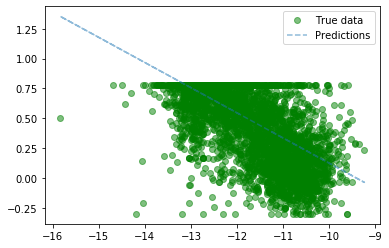

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
#Prepare Data

sSFR=SFR/mass #Calculating sSFR

log_sSFR=np.log10(sSFR)

log_sSFR=np.array(log_sSFR,dtype=np.float32).reshape(-1,1) #Changing data from pd dataframe to arrays to make it easier to feed to Torch 

n=np.array(n,dtype=np.float32).reshape(-1,1)
n=np.log10(n)


#Model 
inputDim=1
outputDim=1 
learningRate=0.1

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array=np.zeros(epochs)
loss_array=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_sSFR).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_sSFR))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    epoch_array[epoch]=epoch 
    loss_array[epoch]=loss.item()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_sSFR).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_sSFR))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_sSFR, n, 'go', label='True data', alpha=0.5)
plt.plot(log_sSFR, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()


In [19]:
model.linear.bias

Parameter containing:
tensor([-1.9913], requires_grad=True)

# 2D Linear Regression using self built model and no CUDA

= [[ 0.00528623 -0.00099846]], b = 0.3542681634426117
t = 1789, loss = 0.04663565754890442, A = [[ 0.00526598 -0.00099464]], b = 0.3544808030128479
t = 1790, loss = 0.046635620296001434, A = [[ 0.0052458  -0.00099083]], b = 0.3546927571296692
t = 1791, loss = 0.04663558304309845, A = [[ 0.00522568 -0.00098702]], b = 0.35490402579307556
t = 1792, loss = 0.046635545790195465, A = [[ 0.00520562 -0.00098323]], b = 0.355114609003067
t = 1793, loss = 0.04663550853729248, A = [[ 0.00518563 -0.00097946]], b = 0.35532453656196594
t = 1794, loss = 0.046635471284389496, A = [[ 0.00516571 -0.0009757 ]], b = 0.35553377866744995
t = 1795, loss = 0.04663543775677681, A = [[ 0.00514584 -0.00097194]], b = 0.35574233531951904
t = 1796, loss = 0.04663539305329323, A = [[ 0.00512604 -0.0009682 ]], b = 0.3559502363204956
t = 1797, loss = 0.046635355800390244, A = [[ 0.00510631 -0.00096448]], b = 0.35615745186805725
t = 1798, loss = 0.04663531854748726, A = [[ 0.00508664 -0.00096076]], b = 0.356364011764526

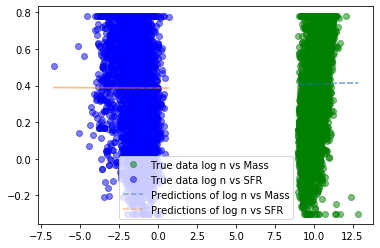

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [37]:
#Two input and one output linear regression 

log_mass_sfr=pd.concat([log_mass,log_SFR],axis=1) #Combining both input variables into one df

log_mass_sfr=np.array(log_mass_sfr,dtype=np.float32).transpose() #Formatting properly for pytorch 

#Defining the model 
# First we define the trainable parameters A and b 
A = torch.randn((1, 2), requires_grad=True)
b = torch.randn(1, requires_grad=True)

def model(x_input):
    return A.mm(x_input) + b

#Chosing a loss function
loss= torch.nn.SmoothL1Loss()

### Training the model ###

# Setup the optimizer object, so it optimizes a and b.
optimizer = torch.optim.Adam([A, b], lr=0.1)

epoch_array2=np.zeros(2000)
loss_array2=np.zeros(2000)
# Main optimization loop
for t in range(2000): #t is epochs

    inputs = Variable(torch.from_numpy(log_mass_sfr))
    labels = Variable(torch.from_numpy(n))

    # Set the gradients to 0.
    optimizer.zero_grad()
    # Compute the current predicted y's from x_dataset
    y_predicted = model(inputs)
    # See how far off the prediction is
    current_loss = loss(y_predicted, labels)
    # Compute the gradient of the loss with respect to A and b.
    current_loss.backward()
    # Update A and b accordingly.
    optimizer.step()

    epoch_array2[t]=t 
    loss_array2[t]=current_loss.item()
    print(f"t = {t}, loss = {current_loss}, A = {A.detach().numpy()}, b = {b.item()}")

plt.plot(log_mass_sfr[0,:], n, 'go', label='True data log n vs Mass', alpha=0.5)
plt.plot(log_mass_sfr[1,:], n, 'bo', label='True data log n vs SFR', alpha=0.5)
plt.plot(log_mass_sfr[0,:], A.detach().numpy()[0][0]*log_mass_sfr[0,:]+b.item(), '--', label='Predictions of log n vs Mass', alpha=0.5)
plt.plot(log_mass_sfr[1,:], A.detach().numpy()[0][1]*log_mass_sfr[1,:]+b.item(), '--', label='Predictions of log n vs SFR', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

In [ ]:
plt.plot()

In [45]:
a = np.array([[1,2,3], [4,5,6]])
b=np.reshape(a,(1,-1))
c=a.flatten()
print(a)
print(b)
print(c)
np.shape(n)



[[1 2 3]
 [4 5 6]]
[[1 2 3 4 5 6]]
[1 2 3 4 5 6]


(3638, 1)

# 2D Linear Regression using torch.nn.Linear and CUDA enabled 

, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1804, loss 0.02402217499911785
tensor(0.0252, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1805, loss 0.025167090818285942
tensor(0.0272, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1806, loss 0.02717139758169651
tensor(0.0305, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1807, loss 0.03053988888859749
tensor(0.0356, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1808, loss 0.035635996609926224
tensor(0.0420, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1809, loss 0.042033519595861435
tensor(0.0470, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1810, loss 0.04698406159877777
tensor(0.0459, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1811, loss 0.04585380107164383
tensor(0.0366, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1812, loss 0.03663603961467743
tensor(0.0259, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1813, loss 0.02590239979326725


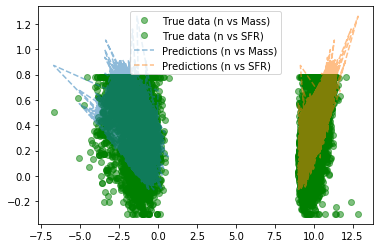

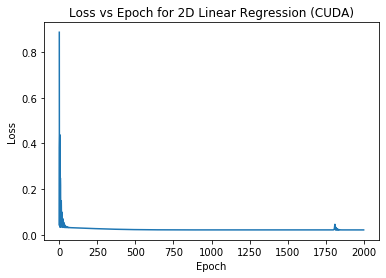

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [46]:
#Model 
inputDim=2
outputDim=1 
learningRate=0.1

log_mass_sfr=pd.concat([log_mass,log_SFR],axis=1) #Combining both input variables into one df

log_mass_sfr=np.array(log_mass_sfr,dtype=np.float32) #Formatting properly for pytorch 


model = torch.nn.Linear(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=2000

epoch_array3=np.zeros(epochs)
loss_array3=np.zeros(epochs)
for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_mass_sfr).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_mass_sfr))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    epoch_array3[epoch]=epoch 
    loss_array3[epoch]=loss.item()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_mass_sfr).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_mass_sfr))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_mass_sfr[:,1], n, 'go', label='True data (n vs Mass)', alpha=0.5)
plt.plot(log_mass_sfr[:,0], n, 'go', label='True data (n vs SFR)', alpha=0.5)
plt.plot(log_mass_sfr[:,1], predicted, '--', label='Predictions (n vs Mass)', alpha=0.5)
plt.plot(log_mass_sfr[:,0], predicted, '--', label='Predictions (n vs SFR)', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()

plt.title('Loss vs Epoch for 2D Linear Regression (CUDA)')
plt.plot(epoch_array3,loss_array3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.figure()

# Doing Linear Regression Using Data Loaders and a 60-20-20 Train-Test-Validate Split

In [69]:
#Importing clean data 

sSFR=SFR/mass #Calculating sSFR
log_sSFR=np.log10(sSFR)
log_sSFR=np.array(log_sSFR,dtype=np.float32)

n=galaxies.loc[:,'nsa_sersic_n']
n=np.log10(n)
n=np.array(n,dtype=np.float32)

#Creating paritions in the data to define the 60-20-20 split 
train_sSFR=log_sSFR[0:2183]
test_sSFR=log_sSFR[2183:2910]
validate_sSFR=log_sSFR[2910:3638]

train_n=n[0:2183]
test_n=n[2183:2910]
validate_n=n[2910:3638]

#Putting these partitions into a pytorch DataLoader 
train_dataloader= DataLoader([train_sSFR,train_n],batch_size=64,shuffle=True)
test_dataloader=DataLoader([test_sSFR,test_n], batch_size=64, shuffle=True)
validate_dataloader= DataLoader([validate_sSFR,validate_n], batch_size=64, shuffle=True)
